In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect

from scipy import optimize
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn

In [44]:
kwargs = {'n_clusters': 3,
          'n_components': 20}

X = np.load("../data/HSI/Liver_map_150z25_60s_1TCPOBOP.npy", 'r')
Y = np.load("../data/HSI/Liver_map_150z25_60s_2TCPOBOP.npy", 'r')

shape_X = X.shape 
shape_Y = Y.shape 

X = copy.copy(X.reshape(-1, X.shape[-1]))
# X /= np.max(X)
Y = copy.copy(Y.reshape(-1, Y.shape[-1]))

In [86]:
class ReferenceVectorClassifier(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = {}
        self.pca_kwargs = {}
        self.k_means_kwargs = {}        
        self.set_params(**kwargs)
        
    def fit(self, X, **kwargs):
        self.set_params(**kwargs)
        ###################### PCA ################################
        pca = decomposition.PCA(**self.pca_kwargs)
        pca.fit(X)
        X_pca = pca.transform(X)

        ###################### clustering ################################
        self.clusters = cluster.KMeans(**self.k_means_kwargs).fit(X_pca)
        self.clusters = self.clusters.labels_
        
        one_hot = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        one_hot[range(X.shape[0]), self.clusters] = 1

        ###################### reference spectra ################################
        self.reference_spectra_ = np.array([X[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])
  
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        
        ###################### RCA ################################
        RCA_vector, error = list(zip(*[optimize.nnls(self.reference_spectra_.T, X[i,:]) for i in range(X.shape[0])]))
        RCA_vector = np.array(RCA_vector)
        self.error = np.array(error)
          
        return RCA_vector  

    def get_params(self, deep=False):
        return self.kwargs
    
    def set_params(self, **kwargs):
        self.kwargs.update(kwargs)
        self.pca_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(decomposition.PCA).parameters.keys())})
        self.k_means_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(cluster.KMeans).parameters.keys())})     
        return self
        
    def score(self, X):
        self.predict(X)
        return -self.error.mean()

In [67]:
################################# cross_val_score #######################
kwargs = {'n_clusters': 3,
          'n_components': 20}

rvc = ReferenceVectorClassifier(**kwargs)
model_selection.cross_val_score(rvc, X, None, scoring=None)


array([0.00066103, 0.00019791, 0.00040848, 0.00047815, 0.0005455 ])

In [101]:
################################# GridSearchCV #######################
kwargs = {'n_clusters': 3,
          'n_components': 20}

rvc = ReferenceVectorClassifier(**kwargs)
clf = model_selection.GridSearchCV(rvc, {'n_clusters': range(3,20)}, scoring=None)
clf.fit(X)
print("best estimator: ", clf.best_estimator_)
print("best score: ", clf.best_score_)

best estimator:  ReferenceVectorClassifier(n_clusters=19, n_components=20)
best score:  -1431.9934761044028


In [102]:
################# predict on original image ###############################
kwargs = {'n_clusters': 3,
          'n_components': 20}
rvc = ReferenceVectorClassifier(**kwargs)
rvc.fit(X)

RCA_vector = rvc.predict(X)

print(rvc.error.mean())

RCA_vector = np.clip(RCA_vector, a_min=0, a_max=1)
plt.figure(figsize = (20,4))
plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_X[:2], kwargs['n_clusters'])),0,1)[:,:,:3])
plt.show()
plt.figure(figsize = (20,4))
plt.imshow(rvc.error.reshape(shape_X[:2]).T)
plt.show()

1262.780053999271


ValueError: cannot reshape array of size 71250 into shape (150,25,3)

<Figure size 1440x288 with 0 Axes>

4560.6688212463405


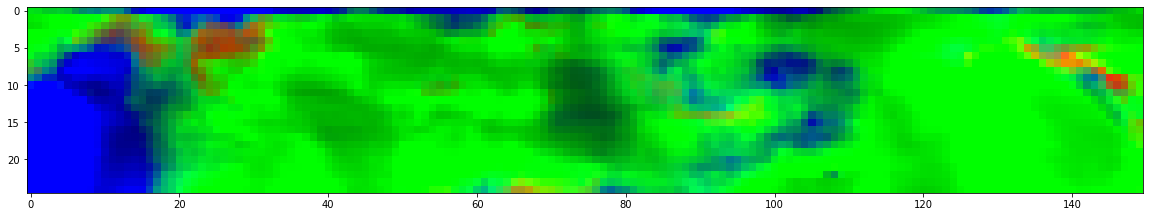

In [5]:
################# predict on new image ###############################
RCA_vector = rvc.predict(Y)

print(rvc.error.mean())

plt.figure(figsize = (20,4))
RCA_vector = np.clip(RCA_vector, a_min=0, a_max=1)
plt.imshow(np.swapaxes(RCA_vector.reshape((*shape_Y[:2], kwargs['n_clusters'])),0,1)[:,:,:3])